<a href="https://colab.research.google.com/github/TCC-NexusParsec/data-analysis/blob/main/dataset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GoogleDrive configs


In [ ]:
!pip install geopandas
!pip install libpysal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 8.6 MB/s 
     |████████████████████████████████| 6.3 MB 12.8 MB/s 
     |████████████████████████████████| 16.7 MB 43.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 8.4 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/Shareddrives/'NEXUS-PARSEC - TCCs'/ProjetoRaf-Car-Igor/Datasets/indicadores_IDH_Nexus

/content/drive/Shareddrives/NEXUS-PARSEC - TCCs/ProjetoRaf-Car-Igor/Datasets/indicadores_IDH_Nexus


In [ ]:
!ls *.csv

IDH_2010.csv  SetoresNexus2010.csv


# Dataset Analysis


In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from shapely.geometry import shape, mapping, Point, MultiPolygon, Polygon, LineString
from shapely.ops import transform, split
from shapely.wkt import loads
import pyproj

import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# DF_PATH = r"C:\ProjetoTCC\IDH_2010.csv"

DF_PATH = r"IDH_2010.csv"

In [ ]:
df = pd.read_csv(DF_PATH, sep=",", quotechar='"', encoding="iso-8859-1")
df["TIPO"] = df["TIPO"].replace("URBANO", "URBAN") # Translate situation name to english

In [ ]:
geo = gpd.GeoDataFrame(df, crs = 'epsg:3857', geometry=[loads(mpoly) for mpoly in df['WKT']])

# geo = geo[~geo.is_empty] # Filtering dataframe for invalid values

# For some reason, this is necessary
geo = geo.to_crs(3857)

geo['centroid'] = geo['geometry'].centroid.to_crs(epsg = 3857)
# Extract lat and lon from the centerpoint
geo["lat"] = geo['centroid'].map(lambda p: p.x)
geo["lon"] = geo['centroid'].map(lambda p: p.y)

geo["area"] = geo["geometry"].area
geo["area"] = geo["area"]/1e6

geo.head()

,Unnamed: 0,year,Cod_setor,TIPO,Cod_municipio,Cod_estado,income,longevity,literacy,WKT,geometry,centroid,lat,lon,area
0,0,2010,270010205000001,URBAN,2700102,27,0.489286,0.733333,0.832084,MultiPolygon (((-4223968.81988941 -1036056.260...,"MULTIPOLYGON (((-4223968.820 -1036056.260, -42...",POINT (-4223476.093 -1036018.684),-4.223476e+06,-1.036019e+06,0.314274
1,1,2010,270010205000002,URBAN,2700102,27,0.512140,0.700000,0.856921,MultiPolygon (((-4223374.68890432 -1034786.203...,"MULTIPOLYGON (((-4223374.689 -1034786.204, -42...",POINT (-4222745.980 -1034974.908),-4.222746e+06,-1.034975e+06,0.762000
2,2,2010,270010205000003,URBAN,2700102,27,0.449489,0.616667,0.901785,MultiPolygon (((-4222960.21502364 -1035667.821...,"MULTIPOLYGON (((-4222960.215 -1035667.821, -42...",POINT (-4222746.181 -1035927.768),-4.222746e+06,-1.035928e+06,0.173091
3,3,2010,270010205000004,RURAL,2700102,27,0.466986,0.750000,0.829106,MultiPolygon (((-4227742.5849558 -1036928.8185...,"MULTIPOLYGON (((-4227742.585 -1036928.819, -42...",POINT (-4227554.348 -1037031.151),-4.227554e+06,-1.037031e+06,0.093654
4,4,2010,270010205000005,RURAL,2700102,27,0.339322,0.700000,0.726252,MultiPolygon (((-4227837.14715099 -1040636.072...,"MULTIPOLYGON (((-4227837.147 -1040636.072, -42...",POINT (-4226268.944 -1036419.984),-4.226269e+06,-1.036420e+06,13.984255


## General Routine:

First, we will separate each municipality and then count how many sectors there are in each of them.
We want to pick, for each municipality, only 25% of the geo sectors, keeping the balance of 50/50 between Rural and Urban sectors.
If the balance is not possible, we only an amount of sectors that correspond to the situation with the less amount

In the end, plot the selected sectors.

In [ ]:
geo.groupby("Cod_municipio")["TIPO"].value_counts()

Cod_municipio  TIPO 
1100304        URBAN      71
               RURAL      21
1502707        URBAN      44
               RURAL      31
1506583        RURAL      33
                        ... 
5222203        URBAN       4
5222302        RURAL      11
               URBAN       2
5300108        URBAN    4175
               RURAL     279
Name: TIPO, Length: 5011, dtype: int64

We split the dataset into two: one for URBAN and other for RURAL, then we check for each of municipality how many sectors are available and do the selection.

When selecting, we need to make sure that we don't take neighboring sectors. If this is possible at a given municipality, we guarantee that we won't have overlapping images. Otherwise, we just ignore the overlap.

In [ ]:
sqr_side = LineString([(0, 0), (6.7, 0)])

wgs84 = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:3857')

project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
utm_point = transform(project, sqr_side)

sqr_side.length

6.7

In [ ]:
def generate_centered_square_vertices(centroid, crs = "EPSG:3857", sqr_size = 6.7e3/2):
    """
    Generate a square centered on centroid = centroid [Point(x,y)] with size = sqr_size, in meters.
    Returns the square vertices.
    """
    centroid = gpd.GeoDataFrame(geometry = gpd.GeoSeries(centroid, crs = crs))
    # Conversion to a coordinate system in meters (EPSG:32634)
    buffer = centroid.to_crs("EPSG:32634").buffer(sqr_size, cap_style = 3) 
    buffer = buffer.to_crs(crs)

    boundaries = buffer.bounds
    p1 = Point((boundaries.minx, boundaries.miny)) # Bottom Left
    p2 = Point((boundaries.maxx, boundaries.miny)) # Bottom Right
    p3 = Point((boundaries.maxx, boundaries.maxy)) # Top Right
    p4 = Point((boundaries.minx, boundaries.maxy)) # Top Left
    vertices = [p1, p2, p3, p4]

    return vertices


def is_sector_inside_cluster(cluster, sector):
    """
    Check if the sector centroid is inside the cluster.
    """
    centroid = sector["centroid"]
    min_x = min([vertice.x for vertice in cluster])
    max_x = max([vertice.x for vertice in cluster])
    min_y = min([vertice.y for vertice in cluster])
    max_y = max([vertice.y for vertice in cluster])
    if centroid.x >= min_x and centroid.x <= max_x:
        if centroid.y >= min_y and centroid.y <= max_y:
            return True
    return False


def find_map_of_sectors(df_mun, selected_sector_code, cluster, clusters_by_internal_sectors):
    """
    Generate a dictionary where keys are the Cod_setor of sectors that reside in
    at least one cluster determined by df_selected_sectors and the value is a dictionary
    that lists all the clusters where the sector resides.
    """
    # TODO: this may be faster by mapping centroids with a function, creating a df of only sectors inside the cluster
    for index, sector in df_mun.iterrows():
        if is_sector_inside_cluster(cluster, sector):
            clusters = clusters_by_internal_sectors.get(sector["Cod_setor"], {})
            clusters[selected_sector_code] = True
            clusters_by_internal_sectors[sector["Cod_setor"]] = clusters
    return clusters_by_internal_sectors


def map_clusters_by_internal_sectors(df_mun, df_selected_sectors):
    """
    Find all sectors that reside in at least one cluster and return a dictionary
    containing this information.
    """
    clusters_by_internal_sectors = {}
    for index, sector in df_selected_sectors.iterrows():
        cluster = generate_centered_square_vertices(sector["centroid"])
        clusters_by_internal_sectors = find_map_of_sectors(df_mun, sector["Cod_setor"], cluster, clusters_by_internal_sectors)
    return clusters_by_internal_sectors


def is_sector_overlapping(sector_code, clusters_by_internal_sectors):
    """
    Check if a sector_code is inside 2 or more clusters
    """
    try:
        if len(clusters_by_internal_sectors[sector_code].keys()) > 1:
          return True
        return False
    
    # In case the key does not exist
    except:
      return False


def count_sector_overlaps(sector_code, clusters_by_internal_sectors):
    """
    Calculate the total of clusters where the sector resides in.
    """
    return len(clusters_by_internal_sectors.get(sector_code, {}).keys())


def find_sectors_overlapping(clusters_by_internal_sectors, df_mun):
    """
    Check each sector inside the municipality, analyzing if it overlaps different clusters.
    Return a list of sectors overlapping.
    """
    max_overlaps = 0
    for index, sector in df_mun.iterrows():
        max_overlaps = max(max_overlaps, 
                           count_sector_overlaps(sector["Cod_setor"], 
                                                 clusters_by_internal_sectors))
        
        # if is_sector_overlapping(sector["Cod_setor"], clusters_by_internal_sectors):
        #    sectors_overlapping.append(sector) # TODO: fix this return to a better type, e.g. dataframe
    return max_overlaps


def evaluate_overlapping(df_mun, df_selected_sectors):
    """
    Analyze clusters formed by the selected sectors by listing all sectors that reside
    in those clusters and checking if they overlap.
    """
    clusters_by_internal_sectors = map_clusters_by_internal_sectors(df_mun, df_selected_sectors)
    max_overlaps = find_sectors_overlapping(clusters_by_internal_sectors, df_mun)
    if not sectors_overlapping:
      return False
    return True


def split_sectors_by_type(df_mun):
    """
    Split municipality dataframe according to type ("URBAN" or "RURAL").
    """
    df_mun_urban = df_mun[df_mun["TIPO"] == "URBAN"]
    df_mun_rural = df_mun[df_mun["TIPO"] == "RURAL"]
    return df_mun_urban, df_mun_rural


def sample_municipality_sectors(df_mun, total_to_select, MAX_ITERATION = 10):
    """
    Sample sectors by type ("URBAN" or "RURAL") from a specified municipality, 
    trying to avoid overlapping between the clusters generated by each sector selected.
    """
    df_mun_urban, df_mun_rural = split_sectors_by_type(df_mun)
    selected_sectors = gpd.GeoDataFrame(None, crs = df_mun.crs) # Create empty GeoDataFrame.
    
    for i in range(1, MAX_ITERATION + 1):
        sel_urban = df_mun_urban.sample(n = total_to_select)
        sel_rural = df_mun_rural.sample(n = total_to_select)
        df_selected_sectors = gpd.GeoDataFrame(pd.concat([sel_urban, sel_rural], ignore_index = True), crs = selected_sectors.crs)
        if not evaluate_overlapping(df_mun, df_selected_sectors):
            return df_selected_sectors, i
    
    return df_selected_sectors, -1


def calculate_total_sectors_per_type(df_mun, PROPORTION = 1/8):
    """
    Calculate the total of sectors to be selected per type ("URBAN" or "RURAL").
    """
    df_urban = df_mun[df_mun["TIPO"] == "URBAN"]
    df_rural = df_mun[df_mun["TIPO"] == "RURAL"]

    total_urban = df_urban.shape[0]
    total_rural = df_rural.shape[0]
    total_sectors = total_urban + total_rural
    total_to_select = int(total_sectors * PROPORTION)

    if total_urban < total_to_select or total_rural < total_to_select: 
        total_to_select = min(total_urban, total_rural)
    return total_to_select


def sample_sectors(df, MAX_ITERATION = 10):
    """
    """
    dataset = gpd.GeoDataFrame(None, crs = geo.crs) # Create empty GeoDataFrame.
    total_attempts_per_municipality = {}

    for mun_code in df["Cod_municipio"].unique():
        df_mun = df[df["Cod_municipio"] == mun_code]
        total_to_select = calculate_total_sectors_per_type(df_mun)

        selected_sectors, total_attempts = sample_municipality_sectors(df_mun, total_to_select, MAX_ITERATION)
        total_attempts_per_municipality [mun_code] = total_attempts

        #if total_attempts != -1:
        print(f"{mun_code}: total_attempts = {total_attempts}, Sectors selected = {selected_sectors.shape[0]}")

        dataset = gpd.GeoDataFrame(pd.concat([dataset, selected_sectors], ignore_index = True), crs = dataset.crs)
    return dataset

In [ ]:
def calculate_combined_polygon(df, cod_mun):
    import libpysal

    df_mun = df[df["Cod_municipio"] ==  cod_mun]
    df_mun_urban = df_mun[df_mun["TIPO"] == "URBAN"].reset_index()

    # create spatial weights matrix
    W = libpysal.weights.Rook.from_dataframe(df_mun_urban)

    # get component labels
    components = W.component_labels

    combined_polygons = df_mun_urban.dissolve(by = components)
    return W, combined_polygons

In [ ]:
def split_rectangle(rectangle, sqr_length =  6.7e3):
  """
  Take a large rectangle and split it into smaller squares of given length.
  Return a list of lists of points that represent the four vertices of each 
  square of the grid (segmented rectangle).
  """
  maxx = rectangle.maxx
  minx = rectangle.minx
  maxy = rectangle.maxy
  miny = rectangle.miny
  width  = maxx - minx
  height = maxy - miny
  total_divisions_x = int(np.round( width/sqr_length))
  total_divisions_y = int(np.round(height/sqr_length))

  h_ticks = np.linspace(minx, maxx, total_divisions_x + 1)
  v_ticks = np.linspace(miny, maxy, total_divisions_y + 1)

  cluster_vertices = []
  for h in range(len(h_ticks) - 1):
    left = h_ticks[h]
    right = h_ticks[h + 1]
    for v in range(len(v_ticks) - 1):
      bottom = v_ticks[v]
      top = v_ticks[v + 1]

      p1 = Point((left, bottom)) # Bottom Left
      p2 = Point((right, bottom)) # Bottom Right
      p3 = Point((right, top)) # Top Right
      p4 = Point((left, top)) # Top Left
      vertices = [p1, p2, p3, p4]
      cluster_vertices.append(vertices)

  return cluster_vertices


def convert_vertices_to_polygon(vertices):
    """
    Get a list of 4 points (vertices) and generate a GeoDataFrame containing a 
    polygon represented by those vertices.
    """
    polygon = Polygon([[vertice.x, vertice.y] for vertice in vertices])
    return gpd.GeoDataFrame(geometry = gpd.GeoSeries(polygon), crs = "EPSG:32634")


def calculate_intersection_polygon(df_polygon_1, df_polygon_2):
    """
    Get two GeoDataFrames containing a Polygon each and calculate a third
    GeoDataFrame containing the intersection of those two, represented by an
    intersection Polygon.
    """
    intersection_polygon = df_polygon_1.intersection(df_polygon_2.geometry)
    return gpd.GeoDataFrame(geometry = gpd.GeoSeries(intersection_polygon), 
                                       crs = "EPSG:32634")


def is_cluster_inside_urban_group(cluster_vertices, df_urban_group, area_threshold = 0.7):
    df_cluster_polygon = convert_vertices_to_polygon(cluster_vertices)
    df_intersection = calculate_intersection_polygon(df_cluster_polygon, df_urban_group)
    
    cluster_area = df_cluster_polygon.area[0]
    intersection_area = df_intersection.area[0]
    return intersection_area/cluster_area >= area_threshold


def calculate_cluster_centroid(cluster_vertices):
    x = (cluster_vertices[0].x + cluster_vertices[1].x) / 2
    y = (cluster_vertices[1].y + cluster_vertices[2].y) / 2
    return Point((x, y))


def create_cluster_grid(df_urban_groups, cluster_length = 6.7e3):
    """
    Take a GeoDataFrame containing urban groups represented by polygons (combined 
    urban sectors), create a grid of possible clusters, calculate which of those
    are relevant, i.e. most of its area is within the urban group. Return the 
    centroids of the relevant clusters.
    """
    src_crs = df_urban_groups.crs
    df_urban_groups = df_urban_groups.to_crs("EPSG:32634")

    ### Plot data
    bbox_list = []
    clusters_vertices_list = []
    ### Plot data

    clusters_centroids = []
    for row in range(df_urban_groups.shape[0]):
        df_urban_group = df_urban_groups.iloc[row:row + 1] # Get row as DataFrame, instead of Series
        bbox = df_urban_group.bounds
        bbox_list.append(bbox)
        clusters_vertices = split_rectangle(bbox, cluster_length)
        clusters_vertices_list.extend(clusters_vertices)
        for vertices in clusters_vertices:
            if is_cluster_inside_urban_group(vertices, df_urban_group):
                cluster_centroid = calculate_cluster_centroid(vertices)
                clusters_centroids.append(cluster_centroid)
    
    return clusters_centroids, bbox_list, clusters_vertices_list

## Plot Functions

In [ ]:
def plot_cluster_coordinates(axis, df, sector_code):
    """
    Plot a map of the municipality which contains the sector represented by the sector_code, 
    showing the sector centroid and the vertices of the image square around it.

    Usage example:
            fig, axis = plt.subplots(1,1, figsize=(20,20))
            plot_cluster_coordinates(df, sector_code, axis)
            axis.tick_params(
                                axis='both', which='both',
                                bottom=False, top=False, labelbottom=False,
                                right=False, left=False, labelleft=False
                            )
            axis.legend()
            plt.show()
    """
    df_sector = df[df["Cod_setor"] == sector_code]
    mun_code = df_sector["Cod_municipio"]
    centroid = df_sector["centroid"]
    cluster = generate_centered_square_vertices(centroid)
    
    ">>>>>>>>>>NOW THERE IS ANOTHER FUNCTION TO PLOT THIS<<<<<<<<<<"
    ">>>>>>>>>>    Check plot_squares()                  <<<<<<<<<<"
    for i in range(4):
      vertice_1 = cluster[i]
      vertice_2 = cluster[(i + 1) % 4]
      axis.plot([vertice_1.x, vertice_2.x], [vertice_1.y, vertice_2.y], alpha = 0.8, linewidth = 1, color = "red", label = "vertices")


def plot_all_sector_centroids(axis, df):
    """
    """
    df_urban = df[df["TIPO"] == "URBAN"]
    df_rural = df[df["TIPO"] == "RURAL"]
    axis.scatter(x = df_urban['lat'], y = df_urban['lon'], alpha = 0.8, linewidth = 0.5, s = 15, color = "orange", label = "Urban")
    axis.scatter(x = df_rural['lat'], y = df_rural['lon'], alpha = 0.8, linewidth = 0.5, s = 15, color = "green", label = "Rural")


def plot_map(axis, df, color = "gray"):
    df["geometry"].plot(ax = axis, facecolor = color, alpha = 0.4, edgecolor = 'black', linewidth = 0.1)


def plot_selected_sectors(axis, df, should_plot_cluster = False):
    if should_plot_cluster:
        for sector_code in df["Cod_setor"].unique():
            plot_cluster_coordinates(df, sector_code, axis)

    df_urban = df[df["TIPO"] == "URBAN"]
    df_rural = df[df["TIPO"] == "RURAL"]
    
    axis.scatter(x = df_urban['lat'], y = df_urban['lon'], alpha = 0.8, linewidth = 0.5, s = 15, color = "blue", label = "Urban")
    axis.scatter(x = df_rural['lat'], y = df_rural['lon'], alpha = 0.8, linewidth = 0.5, s = 15, color = "orange", label = "Rural")


def plot_data(axis, df, df_selected = None, should_plot_cluster = False, should_plot_all_centroids = False):
    legend_custom_text = []
    legend_custom_lines = []

    plot_map(axis, df)

    if df_selected is not None:
        plot_selected_sectors(axis, df_selected, should_plot_cluster)
        legend_custom_text.append("Selected Urban")
        legend_custom_lines.append(Line2D([0], [0], marker='o', markerfacecolor = 'blue',
                                          markersize = 10, color = "blue", lw = 0))
        legend_custom_text.append("Selected Rural")
        legend_custom_lines.append(Line2D([0], [0], marker='o', markerfacecolor = 'orange',
                                          markersize = 10, color = "orange", lw = 0))
        if should_plot_cluster:
            legend_custom_text.append("Cluster boundaries")
            legend_custom_lines.append(Line2D([0], [0], color = "red", lw = 2))

    if should_plot_all_centroids:
        plot_all_sector_centroids(axis, df)
        legend_custom_text.append("All urban sector centroids")
        legend_custom_lines.append(Line2D([0], [0], marker='o', markerfacecolor = 'orange',
                                          markersize = 10, color = "orange", lw = 0))
        legend_custom_text.append("All rural sector centroids")
        legend_custom_lines.append(Line2D([0], [0], marker='o', markerfacecolor = 'green',
                                          markersize = 10, color = "green", lw = 0))

    axis.tick_params(axis='both', which='both',
                     bottom=False, top=False, labelbottom=False,
                     right=False, left=False, labelleft=False
                    )

    axis.legend(legend_custom_lines, legend_custom_text)


def plot_municipality(axis, df, cod_mun, df_selected = None, should_plot_cluster = False, should_plot_all_centroids = False):
    df = df[df["Cod_municipio"] == cod_mun]

    if df_selected is not None:
        df_selected = df_selected[df_selected["Cod_municipio"] == cod_mun]

    plot_data(axis, df, df_selected, should_plot_cluster, should_plot_all_centroids)

In [ ]:
def plot_urban_neighbours_graph(axis, df, W):
    W.plot(df, ax = axis, color = "orange", 
           node_kws = {"marker": ''}, edge_kws = {"linewidth": 0.4, "alpha": 0.8})
    

def plot_urban_components(axis, df, W):
    components = W.component_labels
    combined_polygons = df.dissolve(by = components)
    plot_map(axis, combined_polygons, color = "gold")


def plot_mun_urban_selection_workflow(df, cod_mun, W):
    df_mun = df[df["Cod_municipio"] == cod_mun]
    df_urban = df_mun[df_mun["TIPO"] == "URBAN"].reset_index()

    plt.figure(figsize = (20,40))
    ax1 = plt.subplot(1,2,1)
    plot_municipality(ax1, df, cod_mun, should_plot_all_centroids = True)
    plot_urban_neighbours_graph(ax1, df_urban, W)

    ax2 = plt.subplot(1,2,2)
    plot_municipality(ax2, df, cod_mun, should_plot_all_centroids = True)
    plot_urban_components(ax2, df_urban, W)
    plot_urban_neighbours_graph(ax2, df_urban, W)

    plt.show()

## Execution

cod_mund - quantidade selecionada - status
- 2700102 - 4 - sempre falha, porque os setores urbanos estão muito próximos
- 2700904 - 2 - passa normalmente
- 2701506 - 2 - passa normalmente
- 2701803 - 2 - passa normalmente
- 2703403 - 0 - o município contém menos de 8 setores
- 2703700 - 0 - o município contém menos de 8 setores
- 3546256 - 0 - o município contém menos de 8 setores
- 2910800 - 154 - não consegue selecionar sem overlap
- 2700300 - 58 - não consegue selecionar sem overlap

In [ ]:
# 2700300, 2910800, 3546256, 2700102
df_test = geo[geo["Cod_municipio"].isin([2700300, 2910800, 3546256, 2700102, 2700904, 2701506, 2701803, 2703403, 2703700])]
dataset = sample_sectors(df_test, MAX_ITERATION = 5)

NameError: ignored

In [ ]:
df_test.groupby("Cod_municipio")["TIPO"].value_counts()

In [ ]:
dataset.groupby("Cod_municipio")["TIPO"].value_counts()

In [ ]:
fig, axis = plt.subplots(1,1, figsize=(20,20))
plot_municipality(axis, geo, 2700300, should_plot_all_centroids = True)
plt.show()

Agora, devemos analisar se os setores selecionados não estão muito próximos um do outro, checando o caso de cada município.

- No caso de municípios em que não seja possível remover os overlaps e eles sejam pequenos, seguir com a seleção;
- Caso o overlap seja muito significativo, tratar como um único cluster, fazendo a média dos indicadores dos setores que compõem aquele cluster;
    *   opção 1: não alterar a quantidade de rurais que são selecionados, considerando que o desbalanceamento entre urbano/rural não será tão grande no final
    *   opção 2: tentar encaixar o máximo de clusters urbanos para setores agrupados, diminuindo o desbalanceamento
- Tentar pegar clusters que englobem uma boa parte do municipio

estimação de indicadores socieconomicos: análise de overlapping de áreas urbanas

In [ ]:
def plot_square(vertices, axis, color = "blue", alpha = 0.8, linewidth = 1):
    """
    Takes a list of four vertices and plots the corresponding square.
    """
    df_vertices = gpd.GeoDataFrame(geometry = gpd.GeoSeries(vertices), crs = "EPSG:32634")
    df_vertices = df_vertices.to_crs("EPSG:3857")
    for i in range(4):
        vertice_1 = df_vertices.loc[i].geometry
        vertice_2 = df_vertices.loc[(i + 1) % 4].geometry
        axis.plot([vertice_1.x, vertice_2.x], [vertice_1.y, vertice_2.y], alpha = alpha, linewidth = linewidth, color = color)


def plot_urban_clusters_selection(df, cod_mun):
    legend_custom_text = []
    legend_custom_lines = []
    df_mun = df[df["Cod_municipio"] == cod_mun].to_crs("EPSG:32634")
    df_urban = df_mun[df_mun["TIPO"] == "URBAN"].reset_index()

    fig, axis = plt.subplots(1,1, figsize=(10,10))
    plot_map(axis, df_mun.to_crs("EPSG:3857"))
    plot_urban_components(axis, df_urban.to_crs("EPSG:3857"), W)

    # Plot bboxes
    for bboxes in bbox_list:
        for id, bbox in bboxes.iterrows():
            p1 = Point((bbox.minx, bbox.miny)) # Bottom Left
            p2 = Point((bbox.maxx, bbox.miny)) # Bottom Right
            p3 = Point((bbox.maxx, bbox.maxy)) # Top Right
            p4 = Point((bbox.minx, bbox.maxy)) # Top Left
            vertices = [p1, p2, p3, p4]  
        plot_square(vertices, axis, color = "teal", alpha = 0.7, linewidth = 0.85)

    # Plot bboxes segmentation points
    for vertices in cluster_vertices:
        plot_square(vertices, axis, color="teal", alpha = 0.7, linewidth = 0.85)
    legend_custom_text.append("candidate clusters")
    legend_custom_lines.append(Line2D([0], [0], marker='o', markerfacecolor = 'teal',
                                          markersize = 10, color = "teal", lw = 0))

    # Plot selected clusters
    for centroid in clusters_centroids:
        centroid = gpd.GeoDataFrame(geometry = gpd.GeoSeries(centroid), crs = "EPSG:32634")
        buffer = centroid.buffer(6.7e3/2.175, cap_style = 3)
        boundaries = buffer.bounds
        p1 = Point((boundaries.minx, boundaries.miny)) # Bottom Left
        p2 = Point((boundaries.maxx, boundaries.miny)) # Bottom Right
        p3 = Point((boundaries.maxx, boundaries.maxy)) # Top Right
        p4 = Point((boundaries.minx, boundaries.maxy)) # Top Left
        cluster = [p1, p2, p3, p4] 
        plot_square(cluster, axis, color="red")
    legend_custom_text.append("selected clusters")
    legend_custom_lines.append(Line2D([0], [0], marker='o', markerfacecolor = 'red',
                                          markersize = 10, color = "red", lw = 0))

    plt.legend(legend_custom_lines, legend_custom_text)
    axis.set_title("Urban Grids")
    plt.show()

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)


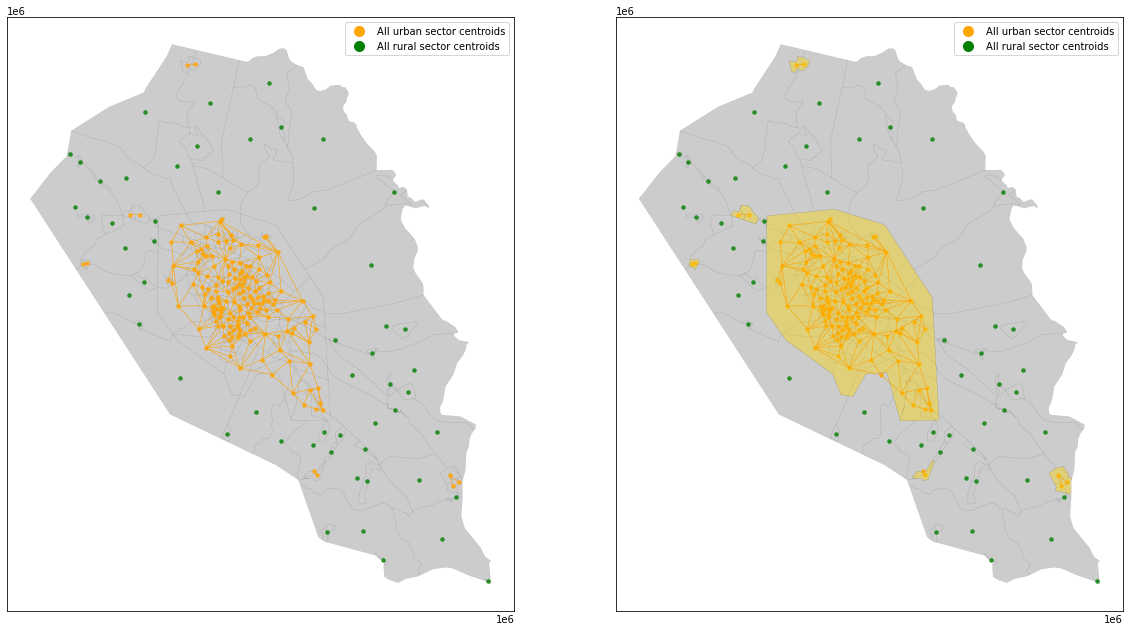

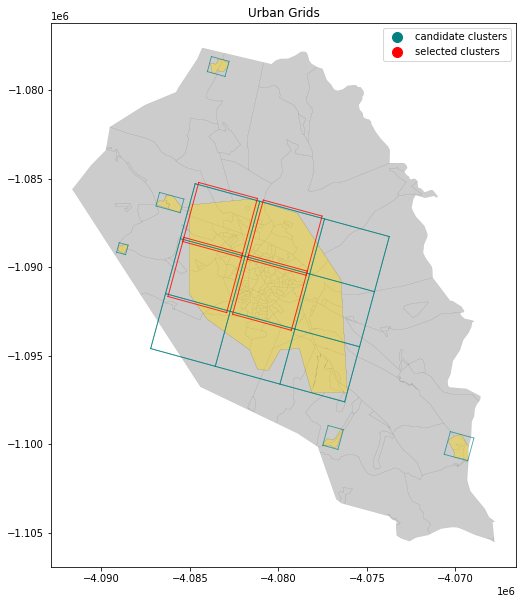

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 5 islands with ids: 336, 571, 572, 575, 576.
  warnings.warn(message)
/usr/local/lib/python3.7/dist-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


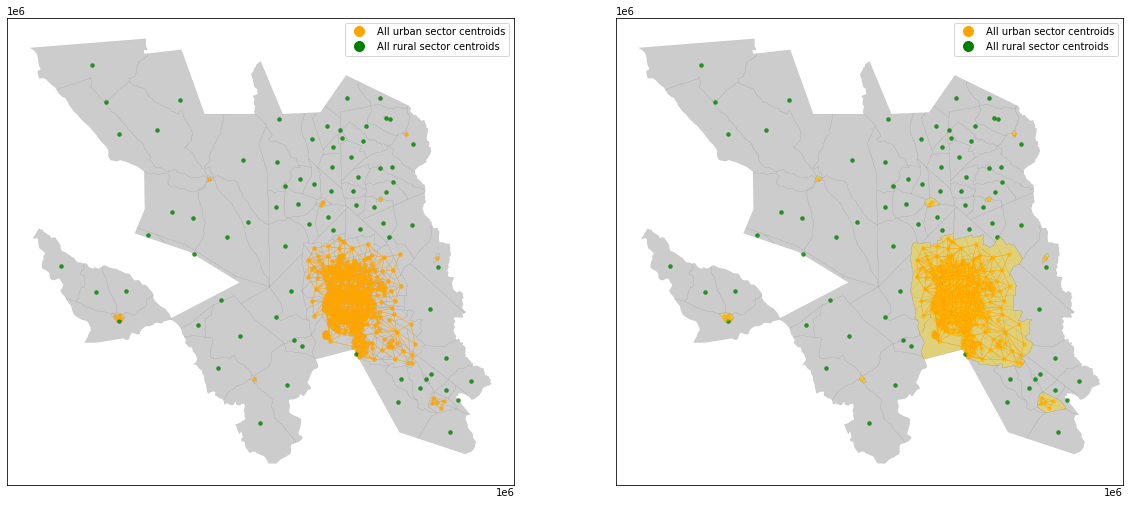

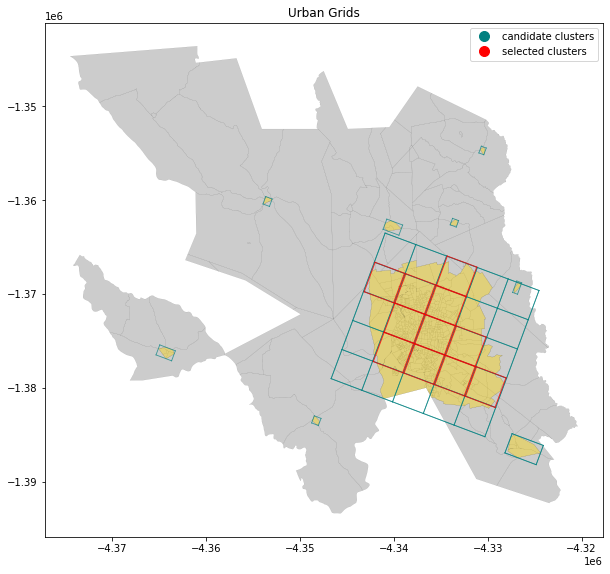

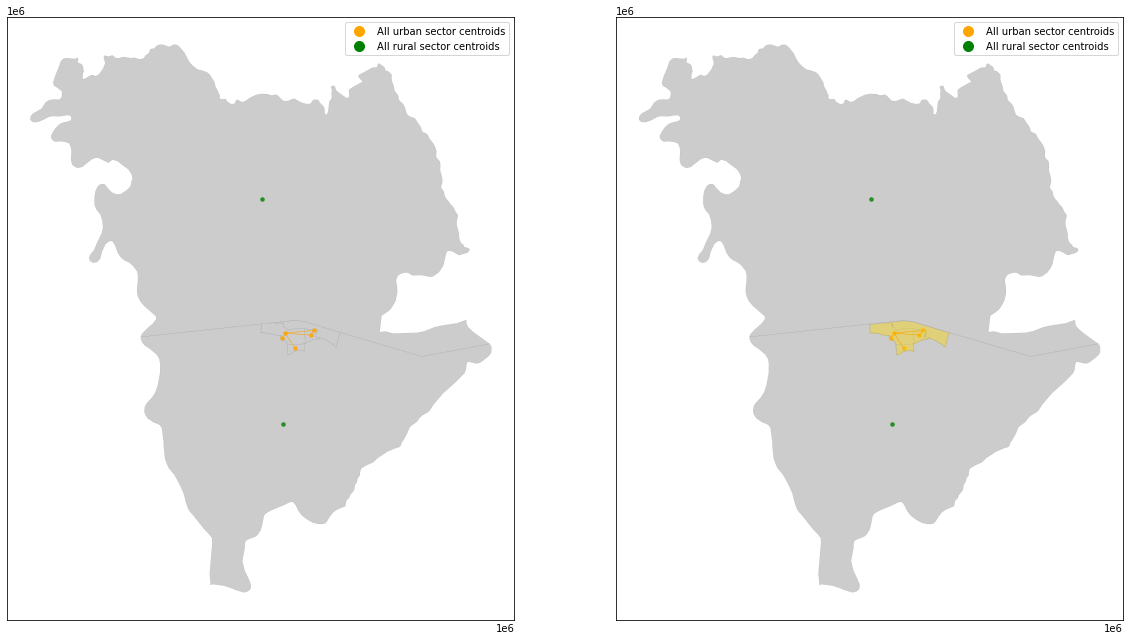

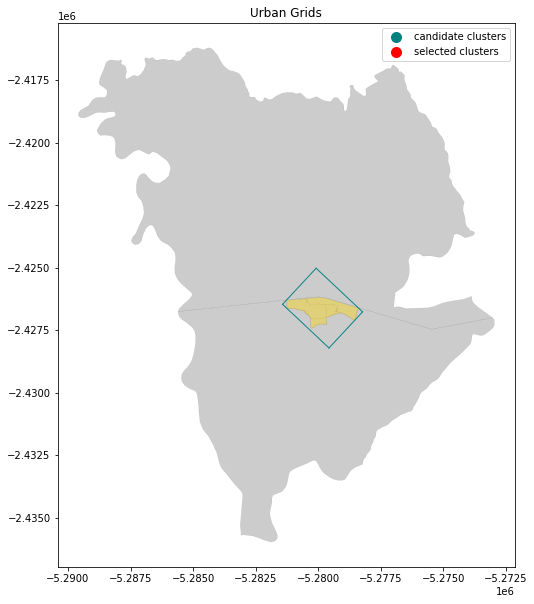

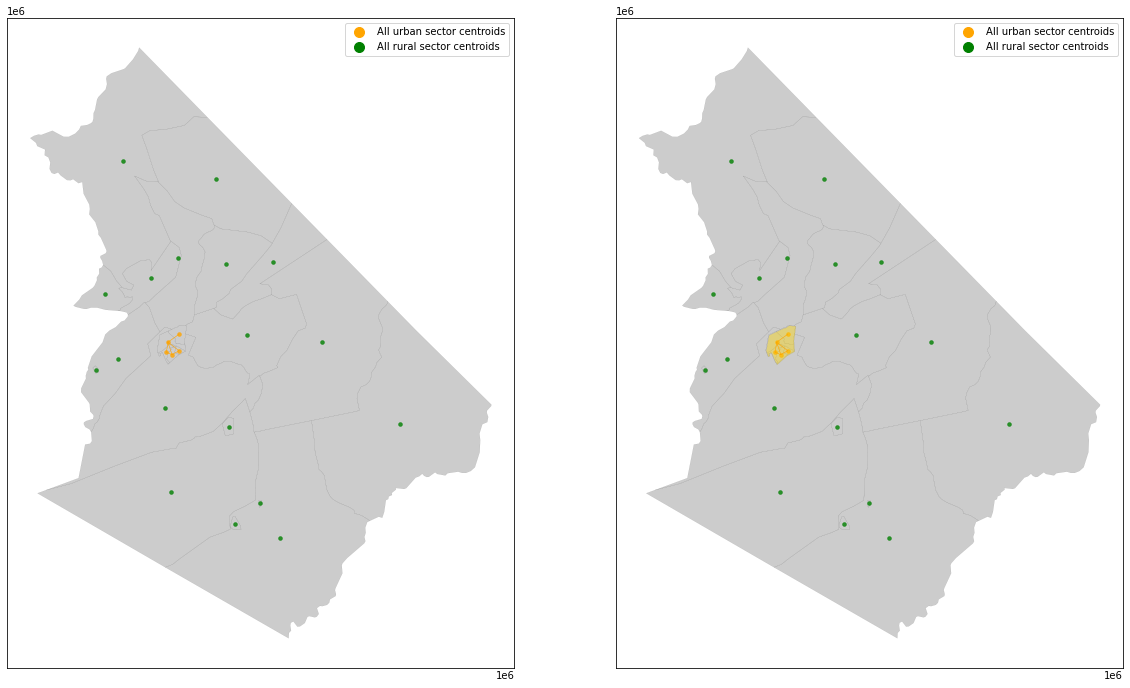

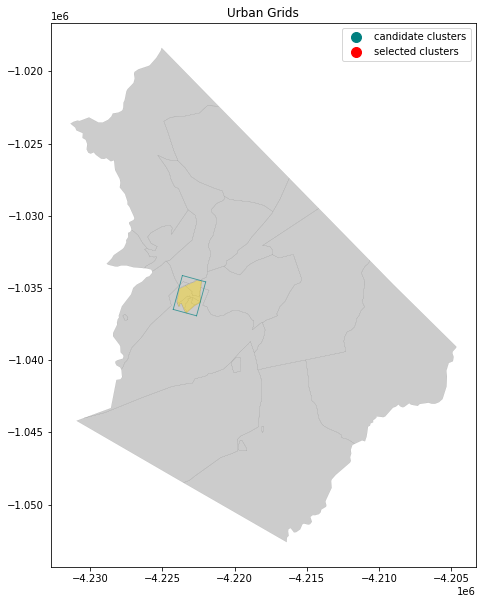

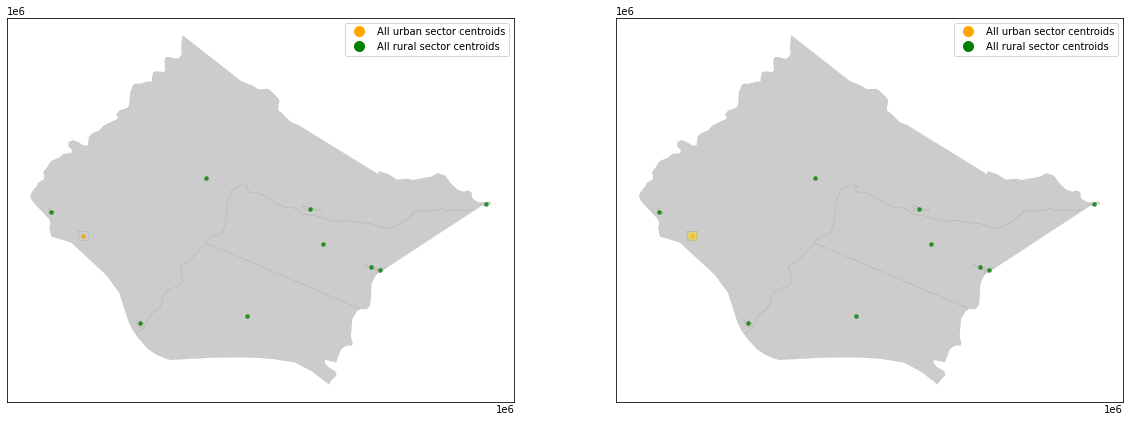

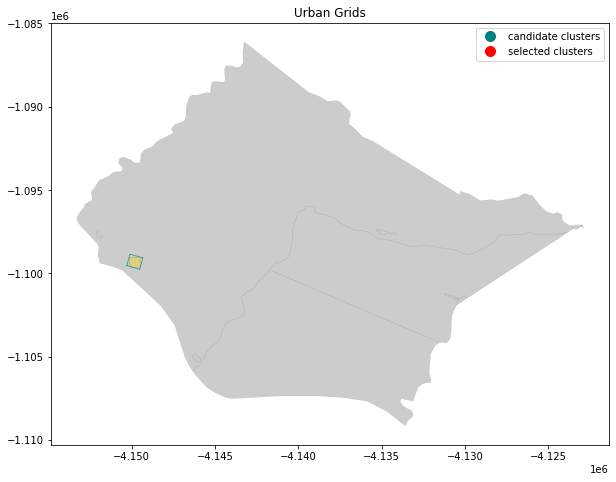

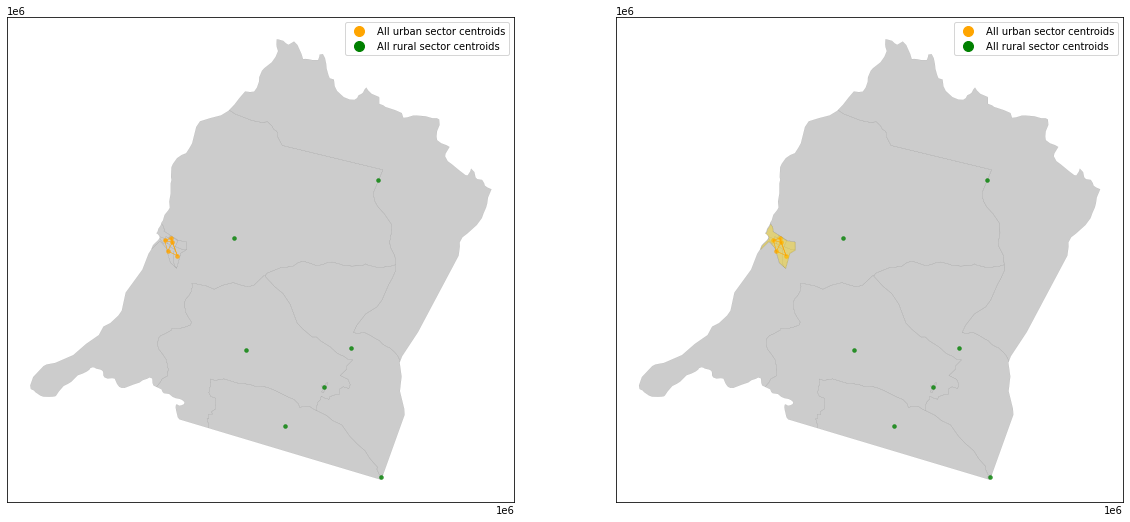

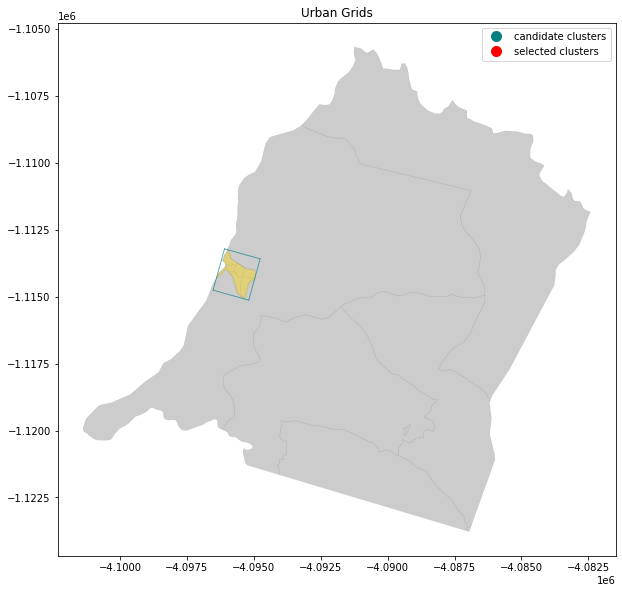

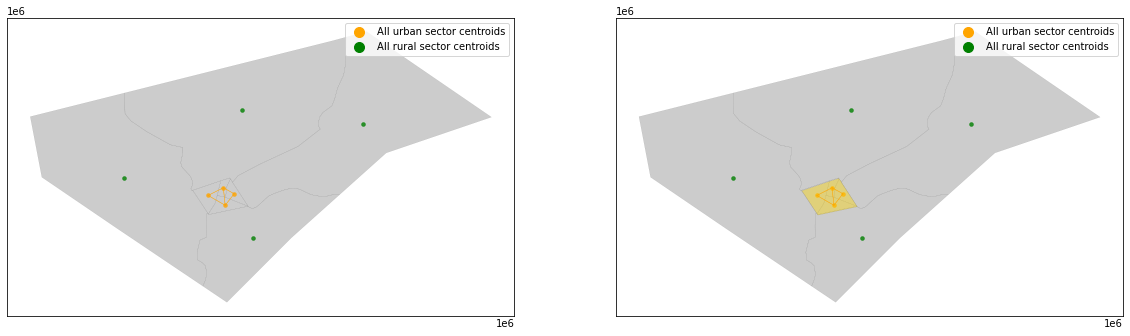

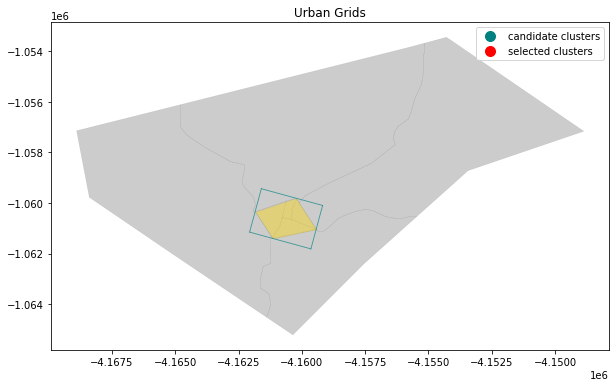

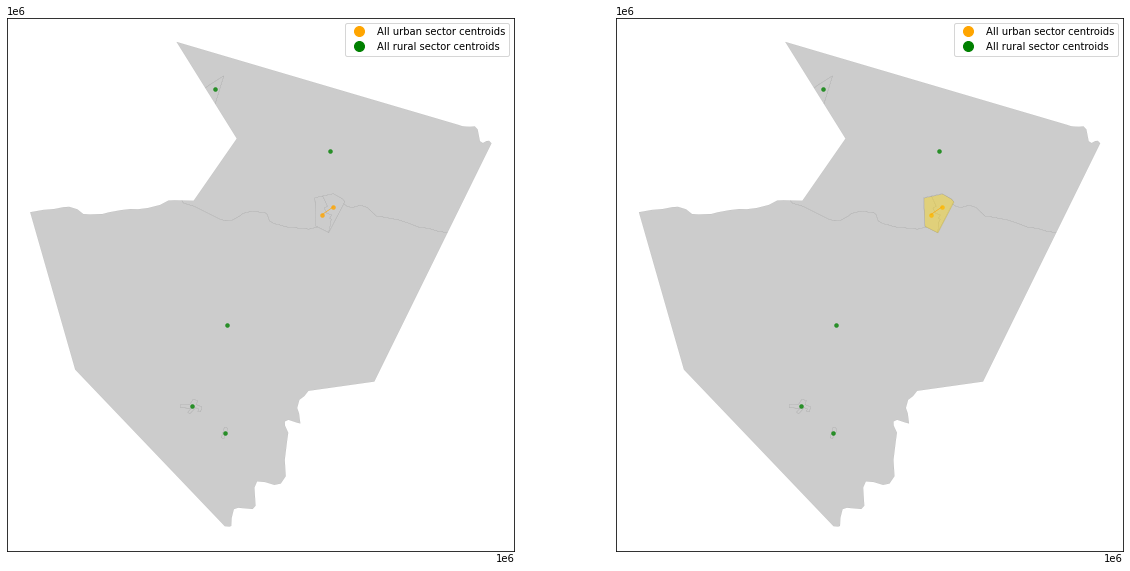

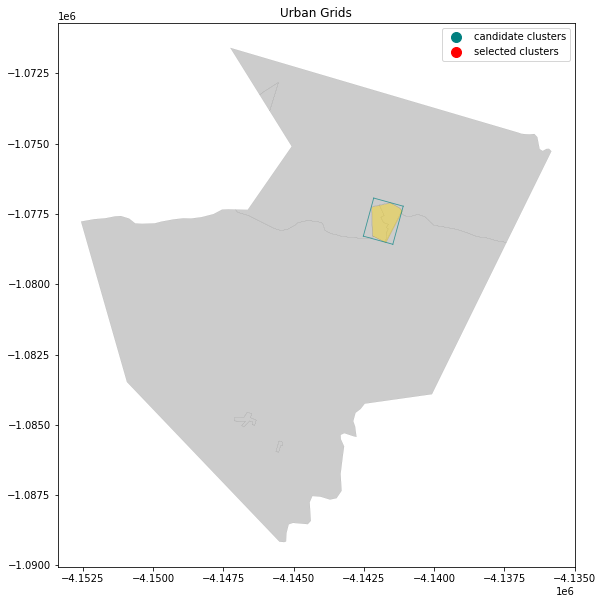

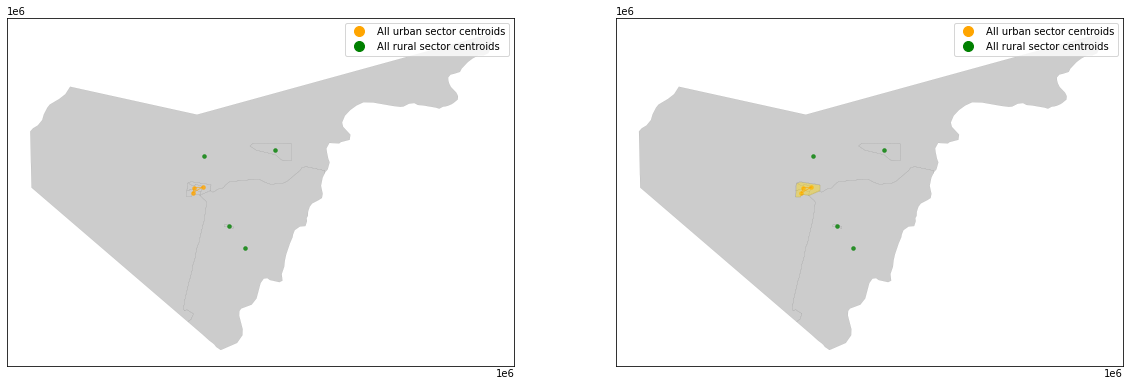

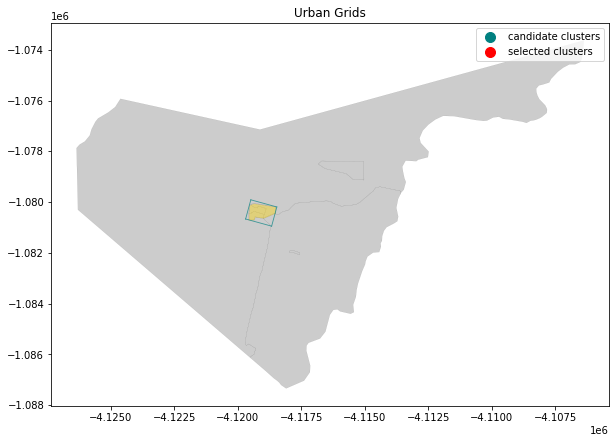

In [ ]:
for cod_mun in [2700300, 2910800, 3546256, 2700102, 2700904, 2701506, 2701803, 2703403, 2703700]:
    W, combined_polygons = calculate_combined_polygon(geo, cod_mun)
    clusters_centroids, bbox_list, cluster_vertices = create_cluster_grid(combined_polygons)
    plot_mun_urban_selection_workflow(geo, cod_mun, W)
    plot_urban_clusters_selection(geo, cod_mun)

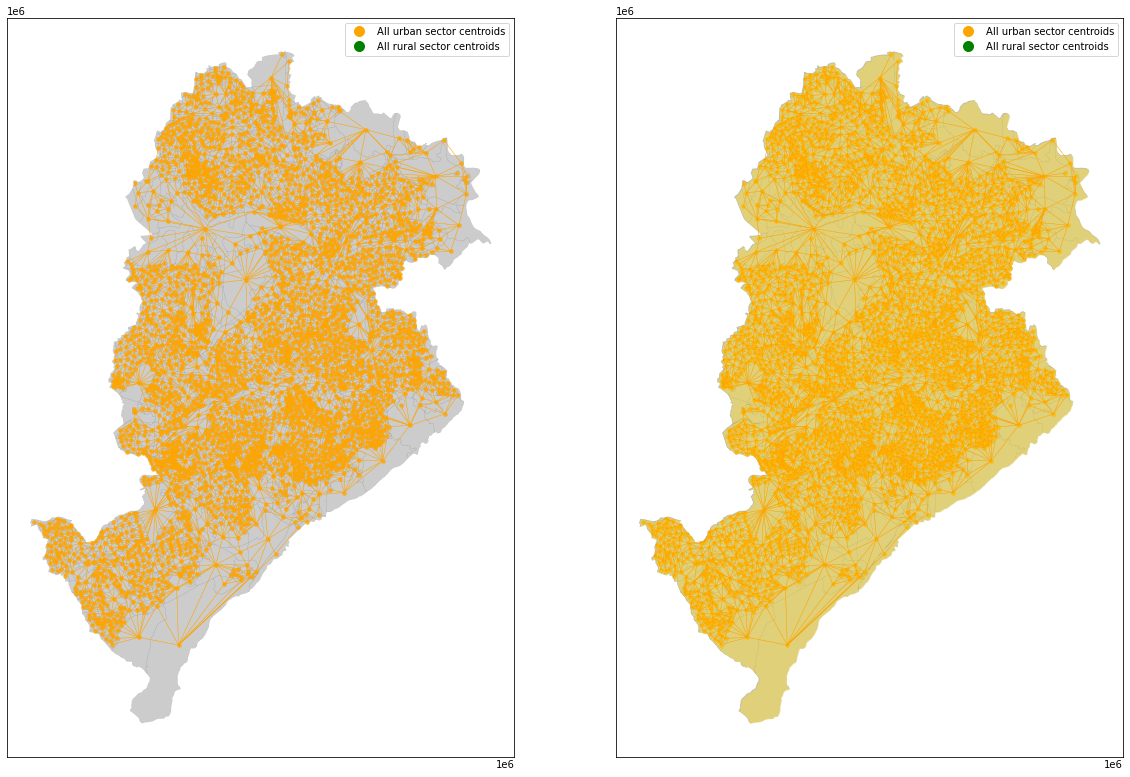

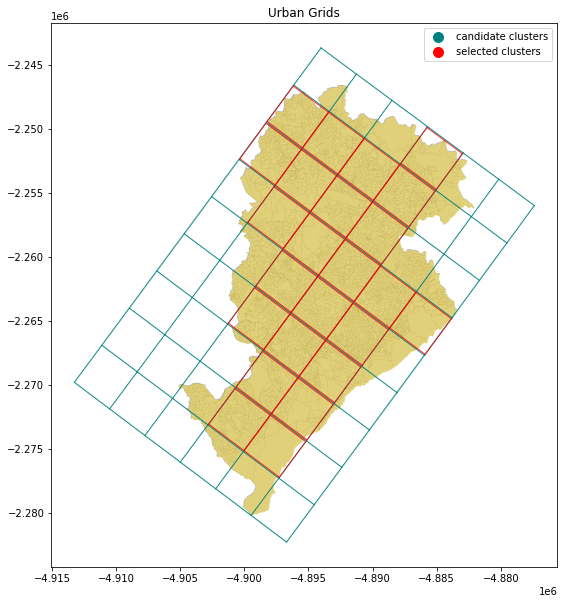

In [ ]:
for cod_mun in [3106200]:
    W, combined_polygons = calculate_combined_polygon(geo, cod_mun)
    clusters_centroids, bbox_list, cluster_vertices = create_cluster_grid(combined_polygons)
    plot_mun_urban_selection_workflow(geo, cod_mun, W)
    plot_urban_clusters_selection(geo, cod_mun)

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 228.
  warnings.warn(message)
/usr/local/lib/python3.7/dist-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


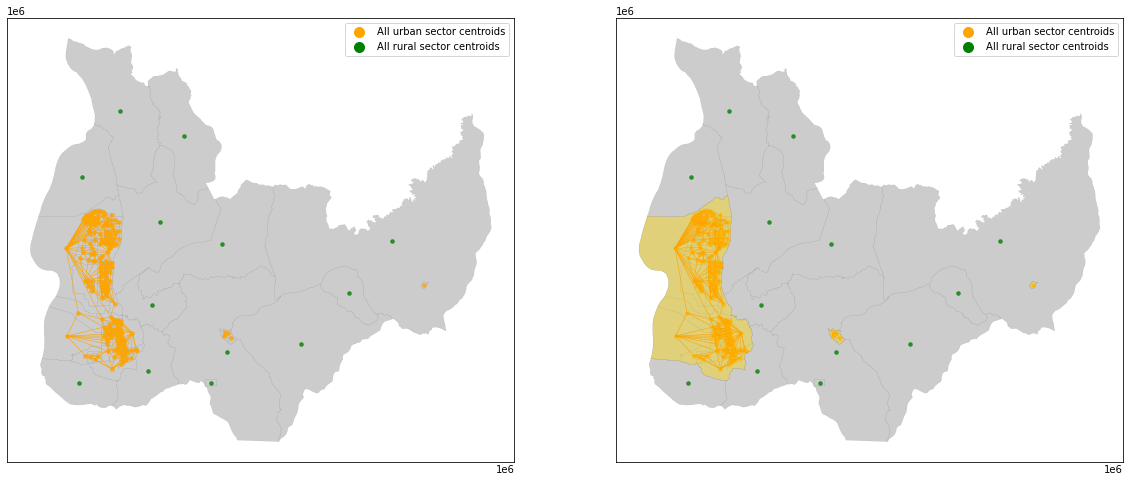

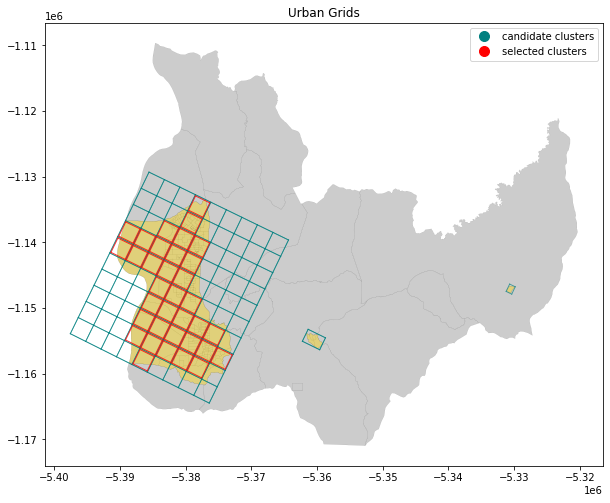

In [ ]:
for cod_mun in [1721000]:
    W, combined_polygons = calculate_combined_polygon(geo, cod_mun)
    clusters_centroids, bbox_list, cluster_vertices = create_cluster_grid(combined_polygons)
    plot_mun_urban_selection_workflow(geo, cod_mun, W)
    plot_urban_clusters_selection(geo, cod_mun)